In [1]:
from pytorch_lightning.callbacks import ModelCheckpoint
# from comet_ml import Experiment

import pytorch_lightning as pl
import os
from plotting import plotting
from torch.nn import functional as FF
from lit_nf import LitNF
from jetnet_dataloader import JetNetDataloader
from helpers import *
from ray import tune
import ray
from pytorch_lightning.loggers import CometLogger
from ray.tune import CLIReporter
from pytorch_lightning.loggers import TensorBoardLogger
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from ray.tune.integration.pytorch_lightning import TuneReportCheckpointCallback
import os
from scipy import stats
import datetime
import pandas as pd
import traceback
import time

In [19]:
import torchinfo
import torch
from jetnet_dataloader import JetNetDataloader
from lit_nf import *
from plotting import *
import pandas as pd
from jetnet.evaluation import w1p, w1efp, w1m, cov_mmd,fpnd
from jetnet.datasets import JetNet
from main import train
pd.set_option("display.max_colwidth",200)
import matplotlib.pyplot as plt
import os
import hist
import mplhep as hep
import torch
import numpy as np
import hist
from hist import Hist
import traceback
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

class plotting_paper():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,true,gen,config,p,model=None,logger=None,weight=1):
        self.config=model.config
        self.n_dim=self.config["n_dim"]
        self.gen=gen
        self.test_set=true

        self.model=model
        self.p=p

        self.weight=weight
        if logger is not None:
            self.summary=logger
    def plot_mass_only(self,m,m_t,bins=15):
        fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(6,8))
        a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
        b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
        a=np.quantile(m_t,0.001)
        b=np.quantile(m_t,0.999)
        h=hist.Hist(hist.axis.Regular(bins,a,b))
        h2=hist.Hist(hist.axis.Regular(bins,a,b))
        bins = h.axes[0].edges
        h.fill(m)#,weight=1/self.weight)
        h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )

        main_ax_artists, sublot_ax_arists = h.plot_ratio(
            h2,
            ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
            rp_ylabel=r"Ratio",
            rp_num_label="Generated",
            rp_denom_label="Ground Truth",
            rp_uncert_draw_type="line",  # line or bar
        )
        ax[0].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')

        ax[1].set_ylim(0.25,2)
        ax[0].set_xlim(a,b)
        ax[1].set_xlabel("$m_T$",fontsize=22)
        ax[1].set_xlim(a,b)
        ax[0].set_ylabel("Counts" ,fontsize=18)
        ax[1].set_ylabel("Ratio",fontsize=18)
        # plt.savefig("{}_mass".format(self.p))
        plt.show()

    def plot_marginals(self,ith=None,title=None,save=None):
        #This plots the marginal distribution for simulation and generation
        #Note that this is the data the model sees during training as input to model in the NF
        #This is the distribution of one of [eta,phi,pt] of one particle of the n particles per jet: for example the pt of the 3rd particle
        #if save, the histograms are logged to tensorboard otherwise they are shown
        
        # plt.switch_backend('agg')
        i=str(ith)

        name,label=["eta","phi","pt"],['${{\eta}}^{{\\tt rel}}_{{{}}}$'.format(ith+1),"${{\phi}}^{{\\tt rel}}_{{{}}}$".format(ith+1),"${{p^{{\\tt rel}}_{{T,{}}}}}$".format(ith+1)]
        fig,ax=plt.subplots(2,3,gridspec_kw={'height_ratios': [3, 1]},figsize=(18,6))
        particles=[3*ith,3*ith+1,3*ith+2]
        pre=""
        if ith!=0:
            pre=str(ith+1)+"."
        plt.suptitle(pre+" Hardest Particle",fontweight="bold",fontsize=18)
        k=0
        for i in particles:


            ax_temp=ax[:,k]
           
            a=np.quantile(self.test_set[:,i].numpy(),0)
            b=np.quantile(self.test_set[:,i].numpy(),1)

            h=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h2=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h.fill(self.gen[:,i].numpy())
            h2.fill(self.test_set[:,i].numpy())
            
            plt.tight_layout()
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0,k] )
       
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax_temp[0],"ratio_ax":ax_temp[1]},
                rp_ylabel=r"Ratio",
#                 rp_xlabel=label[i%3],
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            
            
            ax_temp[0].set_xlabel("")
            ax_temp[1].set_ylim(0.25,2)
            ax_temp[0].set_xlim(a,b)
            ax_temp[1].set_xlim(a,b)
            ax_temp[1].set_xlabel(label[i%3],fontsize=22)
            ax_temp[0].set_ylabel("Counts" ,fontsize=18)
            ax_temp[1].set_ylabel("Ratio",fontsize=18)
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[0,k].get_legend().remove()
            #plt.tight_layout(pad=2)
            k+=1
        ax[0,-1].legend(loc="best",fontsize=18)  
        if not save==None:
            plt.savefig(save+str(ith)+".pdf",format="pdf")
        plt.show()


   
        
    def oversample(self,m,m_t,weight,save=None,quantile=False,bins=15,plot_vline=False,title="",leg=-2):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(20,5))
        plt.suptitle(save)
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i],weight=1/weight)
                
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                
                h.fill(m,weight=1/weight)#,weight=1/self.weight)
                h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
        
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                rp_num_label=r"Generated$\times{}$".format(1./weight),
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')


            ax[1,k].set_ylim(0.25,2)
            ax[0,k].set_xlim(a,b)
            ax[1,k].set_xlabel(name,fontsize=18)
            ax[1,k].set_xlim(a,b)
            ax[0,k].set_ylabel("Counts" ,fontsize=18)
            ax[1,k].set_ylabel("Ratio",fontsize=18)
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[0,k].get_legend().remove()
            plt.tight_layout(pad=1)
            k+=1
        ax[0,leg].legend(loc="best",fontsize=15) 
        if not save==None:
            
                plt.savefig(save+".pdf",format="pdf")

            
    def plot_mass(self,m,m_t,save=None,quantile=False,bins=15,plot_vline=False,title="",leg=-1):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(24,6))
        plt.suptitle("All Particles",fontweight="bold",fontsize=18)
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{\tt rel}$",r"$\phi^{\tt rel}$",r"$p_T^{\tt rel}$",r"$m^{\tt rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                temp=self.test_set[:,i].numpy()
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i])
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                #bins = h.axes[0].edges
                h.fill(m)#,weight=1/self.weight)
                h2.fill(m_t)
                temp=m_t
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
        
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                bar_="blue",
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")
            

            # ax[0,k].patches[1].set_fc("orange")
            # ax[0,k].patches[1].set_alpha(0.5)
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')

            #ax[0,k].hist(temp,bins=bins,color="orange",alpha=0.5)  
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[1,k].set_ylim(0.25,2)
            ax[0,k].set_xlim(a,b)
            ax[1,k].set_xlabel(name,fontsize=22)
            ax[1,k].set_xlim(a,b)
            ax[0,k].set_ylabel("Counts", fontsize=18)
            ax[1,k].set_ylabel("Ratio",fontsize=18)
            ax[0,k].get_legend().remove()
            k+=1
#                 if plot_vline:
#                        ax[0,k].legend(["Generated","Training","10% quantile Gen","10% quantile Sim"] )
#                 else:
#                       ax[0,k].legend(["Flow Generated","MC Simulated"] )
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            
#             plt.xlabel(name)
        
        ax[0,leg].legend(loc="best",fontsize=18)  
        plt.tight_layout(pad=1)
        

        
        if not save==None:
            plt.savefig(save+".pdf",format="pdf")
        plt.show()




In [34]:
config = {
       "network_layers": 4,  # sets amount hidden layers in transformation networks -scannable
        "network_nodes": 256,  # amount nodes in hidden layers in transformation networks -scannable
        "batch_size": 10000,  # sets batch size -scannable
        "coupling_layers": 10,  # amount of invertible transformations to use -scannable
        "lr": 0.001,  # sets learning rate -scannable
        "batchnorm": False,  # use batchnorm or not -scannable
        "bins": 8,  # amount of bins to use in rational quadratic splines -scannable
        "tail_bound": 6,  # splines:max value that is transformed, over this value theree is id  -scannable
        "limit": 150000,  # how many data points to use, test_set is 10% of this -scannable in a sense use 10 k for faster training
        "n_dim": 90,  # how many dimensions to use or equivalently /3 gives the amount of particles to use NEVER EVER CHANGE THIS
        "dropout": 0.4,  # use droput proportion, for 0 there is no dropout -scannable
        "lr_schedule": False,  # whether tos chedule the learning rate can be False or "smart","exp","onecycle" -semi-scannable
        "n_sched": 1000,  # how many steps between an annealing step -semi-scannable
        "canonical": False,  # transform data coordinates to px,py,pz -scannable
        "max_steps": 6000,  # how many steps to use at max - lower for quicker training
        "lambda": 10,  # balance between massloss and nll -scannable
        "n_mse_turnoff": 10000000,  # when to turn off mass loss -scannable
        "n_mse_delay": 5,  # when to turn on mass loss -scannable
        "name": "t",  # name for logging folder
        "disc": False,  # whether to train gan style discriminator that decides whether point is simulated or generated-semi-scannable
        "calc_massloss": False, # whether to calculate mass loss, makes training slower, do not use with autoregressive! 
        "context_features":2, #amount of variables used for conditioning, for 0 no conditioning is used, for 1 o nly the mass is used, for 2 also the number part is used
        "variable":1, #use variable amount of particles otherwise only use 30, options are true or false 
        "spline":"autoreg",#whether to use splines or not, can also be set to "autoregressive" but they are unstable
        "parton":"t", #choose the dataset you want to train options: t for top,q for quark,g for gluon
        "oversampling":False,
        "p":30
    }
model=LitNF(config,128)
data_module=JetNetDataloader(model.config)
q="t"
df=pd.DataFrame()
cname=str(2)
typ="c"
root="/beegfs/desy/user/kaechben/bestmodels_nf/top_{}{}_{}/lightning_logs/".format(typ,cname,q)
print(q+str(cname)+typ,os.path.exists(root))
if os.path.exists(root):
    for file in os.listdir(root):
        if "checkpoints" in os.listdir("/beegfs/desy/user/kaechben/bestmodels_nf/top_{}{}_{}/lightning_logs/{}".format(typ,cname,q,file)):
            w1ms=[]
            w1efps=[]
            fpnds=[]
            names=[]
            typs=[]
            cs=[]
            qs=[]
            ckpts="/beegfs/desy/user/kaechben/bestmodels_nf/top_{}{}_{}/lightning_logs/{}/checkpoints".format(typ,cname,q,file)
            for file2 in os.listdir(ckpts):
                w1ms.append(file2.split("w1m=")[1].split("-")[0])
                w1efps.append(file2.split("w1efp=")[1].split("-")[0])
                fpnds.append(file2.split("fpnd=")[1].split(".c")[0])
                names.append(ckpts+"/"+file2)
                typs.append(typ)
                cs.append(cname)
                qs.append(q)

            temp=pd.DataFrame(np.array([w1ms,w1efps,fpnds,names,typs,cs,qs]).T,columns=["m","efp","fpnd","name","typ","c","q"])
            temp["rank"]=(np.argsort(temp.m.values)+np.argsort(temp.efp.values)+np.argsort(temp.fpnd.values))/3

            df=pd.concat((df,temp),axis=0)
            
from jetnet_dataloader import *
from helpers import *
# This just sets up the dataloader, nothing particularly important. it reads in a csv, calculates mass and reads out the number particles per jet
# And adds it to the dataset as variable. The only important thing is that we add noise to zero padded jets
mo=temp.sort_values("rank").iloc[0]["name"]
name=typ+str(cname)+"_"+q
model=model.load_from_checkpoint(mo)
data_module=JetNetDataloader(model.config)
model.load_datamodule(data_module)
model.data_module.setup("validation")
model.data_module.scaler.to("cpu")  
batch=model.data_module.test_set.to("cpu")
model.flow.eval()
print("loaded")

t2c True
loaded


## Create sliced plots

t2c True


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


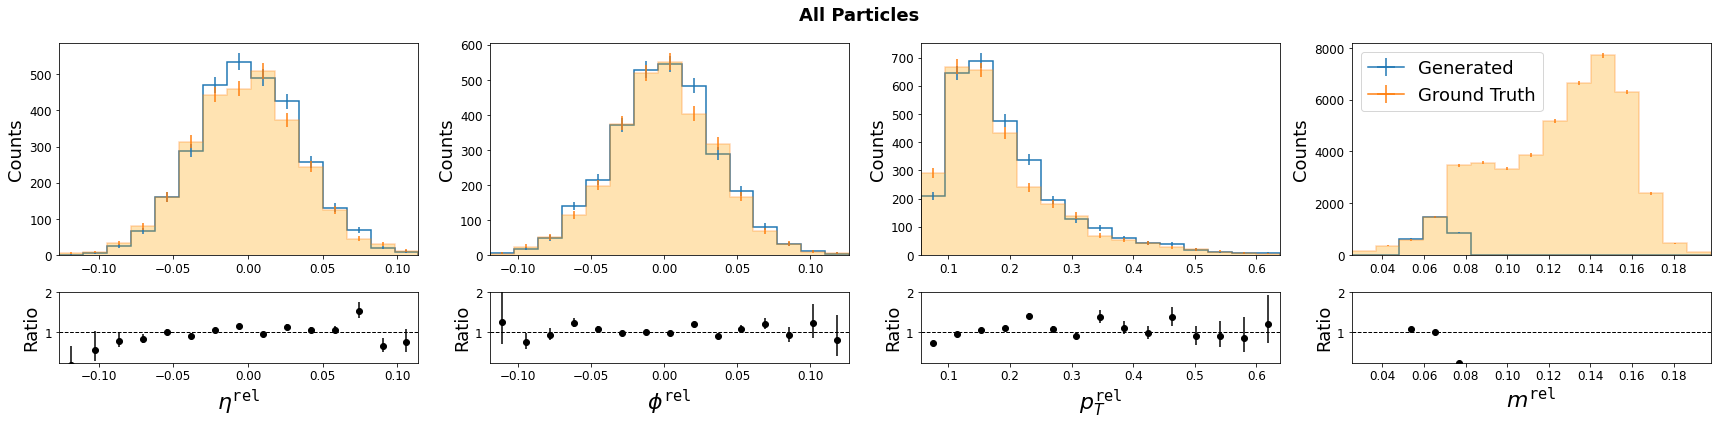

In [7]:

if model.config["context_features"]==1:
    c=batch[:,-2].reshape(-1,1)
    n_true=batch[:,-1]
    batch=batch[:,:model.n_dim+1]

elif model.config["context_features"]==0:
    c=None
    # c_test,n_test=model.test_cond(len(batch))
    # n_true=batch[:,-1]
    # batch=batch[:,:model.n_dim+1]
else:
    c=batch[:,-2:]
    n_true=batch[:,model.n_dim+1]
#c=batch[:,-model.config["context_features"]:] if model.config["context_features"] else None #this is the condition
if model.config["context_features"]>0:
    c_test,n_test=model.test_cond(len(batch)) #this is the condition in the case of testing
    c_test=c_test.reshape(-1,model.config["context_features"])
with torch.no_grad():
    if model.config["context_features"]>0:

        gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1,c).to("cpu")
        test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1, c_test).to("cpu").reshape(-1,90)
        gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
        batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
        test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
    else:
        gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu")
        test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu").reshape(-1,90)
        # batch=batch[:,:model.n_dim]
        gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
        batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
        test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
    # if model.config["oversampling"]:
    #     order=torch.sort(test.reshape(-1,30,3)[:,:,2],dim=1,descending=True)[1]
    #     test=torch.gather(input=test.reshape(-1,30,3),index=order.unsqueeze(-1).repeat(1,1,3),dim=1).reshape(-1,90)
    #test=test.reshape(-1,30,3)[order.repeat(1,1,3)].reshape(-1,90)

# Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
test=model.data_module.scaler.inverse_transform(test)
gen=model.data_module.scaler.inverse_transform(gen)
true=model.data_module.scaler.inverse_transform(batch[:,:model.n_dim+1])[:,:model.n_dim]
# We overwrite in cases where n is smaller 30 the particles after n with 0
if model.config["context_features"]>1:
    for i in torch.unique(batch[:,-1]):
        i=int(i)
        gen[c[:,-1]==i,3*i:-1]=0
        test[c_test[:,-1]==i,3*i:-1]=0
#This is just a nice check to see whether we overtrain 
m_t=mass(true[:,:model.n_dim].to(model.device),model.config["canonical"]).cpu()
m_gen=mass(gen[:,:model.n_dim],model.config["canonical"]).cpu()
m_test=mass(test[:,:model.n_dim],model.config["canonical"]).cpu()
# gen=torch.column_stack((gen[:,:90],m_gen))
test=torch.column_stack((test[:,:90],m_test))       
#SET MIN PT TO 0
for i in range(30):
    i=2+3*i
    gen[gen[:,i]<0,i]=0
    test[test[:,i]<0,i]=0
    true[true[:,i]<0,i]=0
    #Some metrics we track
cov,mmd=cov_mmd(true[:,:model.n_dim].reshape(-1,model.n_dim//3,3),test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),use_tqdm=False)
try:
    fpndv=fpnd(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3).numpy(),use_tqdm=False,jet_type=model.config["parton"])
except:
    fpndv=1000
a=0.05
b=0.075
test=test[(m_test>a)&(m_test<b)]
true=true[(m_t>a)&(m_t<b)]
model.plot=plotting_paper(model=model,gen=test[:,:model.n_dim],true=true[:,:model.n_dim],config=model.config,p=config["parton"])

try:
model.plot.plot_mass(m_test[(m_test>a)&(m_test<b)].cpu().numpy(),m_t.cpu().numpy(),save="conditioned_mass_between{}_{}".format(a,b),bins=15,quantile=True,plot_vline=False)
#             model.plot.plot_marginals(save=True)
#       model.plot.var_part(true=true[:,:model.n_dim],gen=test[:,:model.n_dim],true_n=n_true,gen_n=n_test,m_true=m_t,m_gen=m_test ,save=True)
except Exception as e:
traceback.print_exc()

        # #         model.flow.to("cuda")
        #     model.plot.plot_correlations()



## Oversampling

In [35]:
weight=1000
if model.config["context_features"]==1:
    c=batch[:,-2].reshape(-1,1)
    n_true=batch[:,-1]
    batch=batch[:,:model.n_dim+1]

elif model.config["context_features"]==0:
    c=None
    # c_test,n_test=model.test_cond(len(batch))
    # n_true=batch[:,-1]
    # batch=batch[:,:model.n_dim+1]
else:
    c=batch[:,-2:]
    n_true=batch[:,model.n_dim+1]
#c=batch[:,-model.config["context_features"]:] if model.config["context_features"] else None #this is the condition
# if model.config["context_features"]>0:
#     c_test,n_test=model.test_cond(len(batch)) #this is the condition in the case of testing
#     c_test=c_test.reshape(-1,model.config["context_features"])
batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
test=torch.empty((0,91))
for i in range(weight):
    with torch.no_grad():
        if model.config["context_features"]>0:
            temptest=model.flow_test.to("cpu").sample(len(batch) if c==None else 1, c_test).to("cpu").reshape(-1,90)
            test=torch.cat((test,torch.hstack((temptest[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(temptest)).unsqueeze(1)))),axis=0)

# Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
test=model.data_module.scaler.inverse_transform(test)

true=model.data_module.scaler.inverse_transform(batch[:,:model.n_dim+1])[:,:model.n_dim]
# We overwrite in cases where n is smaller 30 the particles after n with 0



KeyboardInterrupt: 

In [38]:
test=model.data_module.scaler.inverse_transform(test)
gen=model.data_module.scaler.inverse_transform(gen)
true=model.data_module.scaler.inverse_transform(batch[:,:model.n_dim+1])[:,:model.n_dim]
len(test)/len(true)

456.0

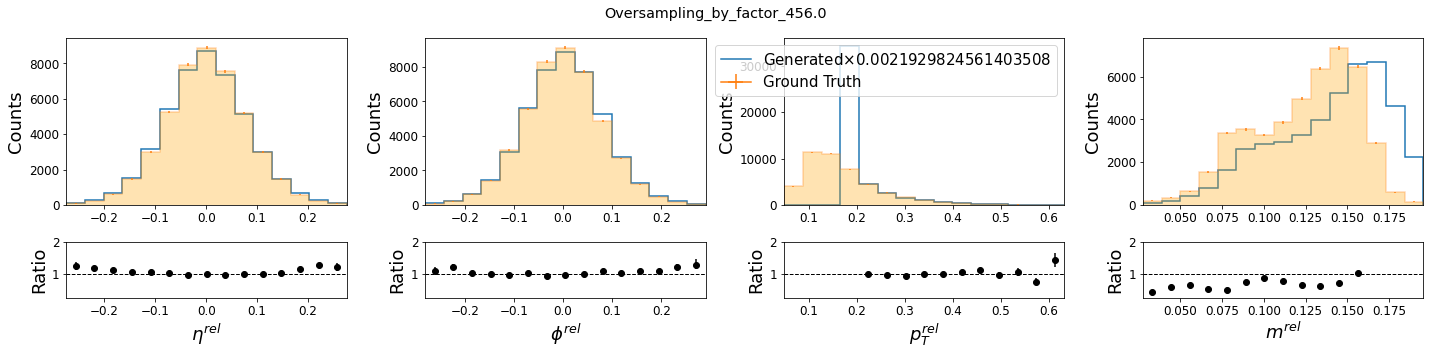

In [39]:
# if model.config["context_features"]>1:
#     for i in torch.unique(batch[:,-1]):
#         i=int(i)
#         gen[c[:,-1]==i,3*i:-1]=0
#         test[c_test[:,-1]==i,3*i:-1]=0
#This is just a nice check to see whether we overtrain 
weight=len(test)/len(true)
m_t=mass(true[:,:model.n_dim].to(model.device),model.config["canonical"]).cpu()
m_gen=mass(gen[:,:model.n_dim],model.config["canonical"]).cpu()
m_test=mass(test[:,:model.n_dim],model.config["canonical"]).cpu()
# gen=torch.column_stack((gen[:,:90],m_gen))
test=torch.column_stack((test[:,:90],m_test))       
#SET MIN PT TO 0
for i in range(30):
    i=2+3*i
    gen[gen[:,i]<0,i]=0
    test[test[:,i]<0,i]=0
    true[true[:,i]<0,i]=0
    #Some metrics we track

model.plot=plotting_paper(model=model,gen=test[:,:model.n_dim],true=true[:,:model.n_dim],config=model.config,p=config["parton"])


model.plot.oversample(m_test.cpu().numpy(),m_t.cpu().numpy(),save="Oversampling_by_factor_{}".format(weight),weight=weight,bins=15,quantile=True,plot_vline=False)
#             model.plot.plot_marginals(save=True)
#       model.plot.var_part(true=true[:,:model.n_dim],gen=test[:,:model.n_dim],true_n=n_true,gen_n=n_test,m_true=m_t,m_gen=m_test ,save=True)

        # #         model.flow.to("cuda")
        #     model.plot.plot_correlations()


## To recreate results table run below 2 cells

In [22]:
q="t"
df=pd.DataFrame()
results_df=pd.DataFrame()
for q in ["g","q","t"]:
    for c in [0,1,2]:
        cname=str(c)
        for typ in ["c","cc"]:
            root="/beegfs/desy/user/kaechben/bestmodels_nf/top_{}{}_{}/lightning_logs/".format(typ,cname,q)
            print(q+str(cname)+typ,os.path.exists(root))
            if os.path.exists(root):
                for file in os.listdir(root):
                    if "checkpoints" in os.listdir("/beegfs/desy/user/kaechben/bestmodels_nf/top_{}{}_{}/lightning_logs/{}".format(typ,cname,q,file)):
                        w1ms=[]
                        w1efps=[]
                        fpnds=[]
                        names=[]
                        typs=[]
                        cs=[]
                        qs=[]
                        ckpts="/beegfs/desy/user/kaechben/bestmodels_nf/top_{}{}_{}/lightning_logs/{}/checkpoints".format(typ,cname,q,file)
                        for file2 in os.listdir(ckpts):
                            w1ms.append(file2.split("w1m=")[1].split("-")[0])
                            w1efps.append(file2.split("w1efp=")[1].split("-")[0])
                            fpnds.append(file2.split("fpnd=")[1].split(".c")[0])
                            names.append(ckpts+"/"+file2)
                            typs.append(typ)
                            cs.append(cname)
                            qs.append(q)
                            
                        temp=pd.DataFrame(np.array([w1ms,w1efps,fpnds,names,typs,cs,qs]).T,columns=["m","efp","fpnd","name","typ","c","q"])
                        temp["rank"]=(np.argsort(temp.m.values)+np.argsort(temp.efp.values)+np.argsort(temp.fpnd.values))/3
                        
                        df=pd.concat((df,temp),axis=0)
                from jetnet_dataloader import *
                from helpers import *
                # This just sets up the dataloader, nothing particularly important. it reads in a csv, calculates mass and reads out the number particles per jet
                # And adds it to the dataset as variable. The only important thing is that we add noise to zero padded jets
                mo=temp.sort_values("rank").iloc[0]["name"]
                name=typ+str(cname)+"_"+q
                model=model.load_from_checkpoint(mo)
                data_module=JetNetDataloader(model.config)
                model.load_datamodule(data_module)
                model.data_module.setup("validation")
                model.data_module.scaler.to("cpu")  
                batch=model.data_module.test_set.to("cpu")
                model.flow.eval()
                print(model.config)
                if model.config["context_features"]==1:
                    c=batch[:,-2].reshape(-1,1)
                    n_true=batch[:,-1]
                    batch=batch[:,:model.n_dim+1]
                    
                elif model.config["context_features"]==0:
                    c=None
                    # c_test,n_test=model.test_cond(len(batch))
                    # n_true=batch[:,-1]
                    # batch=batch[:,:model.n_dim+1]
                else:
                    c=batch[:,-2:]
                    n_true=batch[:,model.n_dim+1]
                #c=batch[:,-model.config["context_features"]:] if model.config["context_features"] else None #this is the condition
                if model.config["context_features"]>0:
                    c_test,n_test=model.test_cond(len(batch)) #this is the condition in the case of testing
                    c_test=c_test.reshape(-1,model.config["context_features"])
                with torch.no_grad():
                    if model.config["context_features"]>0:

                        gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1,c).to("cpu")
                        test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1, c_test).to("cpu").reshape(-1,90)
                        gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
                        batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
                        test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
                    else:
                        gen=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu")
                        test=model.flow_test.to("cpu").sample(len(batch) if c==None else 1).to("cpu").reshape(-1,90)
                        # batch=batch[:,:model.n_dim]
                        gen=torch.hstack((gen[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))) 
                        batch=torch.hstack((batch[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1)))                
                        test=torch.hstack((test[:,:model.n_dim].cpu().detach().reshape(-1,model.n_dim),torch.ones(len(test)).unsqueeze(1)))
                    # if model.config["oversampling"]:
                    #     order=torch.sort(test.reshape(-1,30,3)[:,:,2],dim=1,descending=True)[1]
                    #     test=torch.gather(input=test.reshape(-1,30,3),index=order.unsqueeze(-1).repeat(1,1,3),dim=1).reshape(-1,90)
                    #test=test.reshape(-1,30,3)[order.repeat(1,1,3)].reshape(-1,90)
                
                # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
                test=model.data_module.scaler.inverse_transform(test)
                gen=model.data_module.scaler.inverse_transform(gen)
                true=model.data_module.scaler.inverse_transform(batch[:,:model.n_dim+1])[:,:model.n_dim]
                # We overwrite in cases where n is smaller 30 the particles after n with 0
                if model.config["context_features"]>1:
                    for i in torch.unique(batch[:,-1]):
                        i=int(i)
                        gen[c[:,-1]==i,3*i:-1]=0
                        test[c_test[:,-1]==i,3*i:-1]=0
                #This is just a nice check to see whether we overtrain 
                logprob = -model.flow.to("cpu").log_prob(batch[:,:model.n_dim],c     ).detach().mean().numpy()/model.n_dim
                # if model.global_step > 100:
                #     if logprob > 1: ###Cut off logprob value
                #         raise ValueError('Logprob over 1')
                #calculate mass distrbutions & concat them to training sample
                m_t=mass(true[:,:model.n_dim].to(model.device),model.config["canonical"]).cpu()
                m_gen=mass(gen[:,:model.n_dim],model.config["canonical"]).cpu()
                m_test=mass(test[:,:model.n_dim],model.config["canonical"]).cpu()
                # gen=torch.column_stack((gen[:,:90],m_gen))
                test=torch.column_stack((test[:,:90],m_test))       
                # Again checking for overtraining
                mse=FF.mse_loss(m_t,m_gen).detach()
                
                    
                for i in range(30):
                    i=2+3*i
                    gen[gen[:,i]<0,i]=0
                    test[test[:,i]<0,i]=0
                    true[true[:,i]<0,i]=0
                    #Some metrics we track
                cov,mmd=cov_mmd(true[:,:model.n_dim].reshape(-1,model.n_dim//3,3),test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),use_tqdm=False)
                try:
                    fpndv=fpnd(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3).numpy(),use_tqdm=False,jet_type=model.config["parton"])
                except:
                    fpndv=1000
                model.metrics["val_fpnd"].append(fpndv)
                model.metrics["val_logprob"].append(logprob)
                model.metrics["val_mmd"].append(mmd)
                model.metrics["val_cov"].append(cov)
                model.metrics["val_w1p"].append(w1p(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),true[:,:model.n_dim].reshape(-1,model.n_dim//3,3)))
                model.metrics["val_w1m"].append(w1m(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),true[:,:model.n_dim].reshape(-1,model.n_dim//3,3)))
                model.metrics["val_w1efp"].append(w1efp(test[:,:model.n_dim].reshape(-1,model.n_dim//3,3),true[:,:model.n_dim].reshape(-1,model.n_dim//3,3)))
                
                
                temp_={"logprob":logprob,"fpnd":fpndv,"mmd":mmd,"cov":cov,"w1m":model.metrics["val_w1m"][-1][0],"w1efp":model.metrics["val_w1efp"][-1][0],"w1p":model.metrics["val_w1p"][-1][0],"name":mo,"w1pe":model.metrics["val_w1p"][-1][1],"w1me":model.metrics["val_w1m"][-1][1],"w1efpe":model.metrics["val_w1efp"][-1][1]}
                print(name,temp_)
                results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))
                # This part here adds the plots to tensorboard
                
                # model.plot=plotting_paper(model=model,gen=gen[:,:model.n_dim],true=true[:,:model.n_dim],config=model.config,p=config["parton"])
                # model.plot.plot_mass(m_test.cpu().numpy(),m_t.cpu().numpy(),save=name+"_inclusive",bins=15,leg=-2)
                # for i in [0,5,7,25]:

                #     model.plot.plot_marginals(save=name+"_marginals_",ith=i)

                #     try:
                #         model.plot.plot_mass(m_test.cpu().numpy(),m_t.cpu().numpy(),save=True,bins=15,quantile=True,plot_vline=False)
                # #             model.plot.plot_marginals(save=True)
                #         model.plot.plot_2d(save=True)
                #         model.plot.losses(save=True)
                #         model.plot.var_part(true=true[:,:model.n_dim],gen=test[:,:model.n_dim],true_n=n_true,gen_n=n_test,m_true=m_t,m_gen=m_test ,save=True)
                #     except Exception as e:
                #         traceback.print_exc()
                        
                # #         model.flow.to("cuda")
                #     model.plot.plot_correlations()
                
                        

g0c True


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


{'network_layers': 4, 'network_nodes': 294, 'batch_size': 10000, 'coupling_layers': 10, 'lr': 0.0001052411392693, 'batchnorm': True, 'bins': 6, 'tail_bound': 8, 'limit': 150000, 'n_dim': 90, 'dropout': 0.4183396136763045, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.0191483740736913, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': False, 'context_features': 0, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


c0_g {'logprob': 0.3135752360026042, 'fpnd': 2.317308117906805, 'mmd': 0.03541245891476915, 'cov': 0.5449999999999999, 'w1m': 0.005548636921476572, 'w1efp': 4.3685632525894054e-05, 'w1p': 0.0028823615403080357, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c0_g/lightning_logs/version_0/checkpoints/epoch=2899-val_logprob=0.39-val_w1m=0.0053-val_w1efp=0.000042-val_fpnd=2.18.ckpt', 'w1pe': 0.0006650634836469642, 'w1me': 0.0006747035167593456, 'w1efpe': 7.6289556688156e-06}
g0cc True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


{'network_layers': 5, 'network_nodes': 144, 'batch_size': 10000, 'coupling_layers': 16, 'lr': 0.0001625139195757, 'batchnorm': True, 'bins': 5, 'tail_bound': 9, 'limit': 150000, 'n_dim': 90, 'dropout': 0.0123259819793513, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 2.1150973762334067, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': True, 'context_features': 0, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


cc0_g {'logprob': 0.37586835225423176, 'fpnd': 1.403572073067636, 'mmd': 0.03661912850060975, 'cov': 0.542, 'w1m': 0.0028115092625096436, 'w1efp': 3.482955961460684e-05, 'w1p': 0.0014869732004440309, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc0_g/lightning_logs/version_0/checkpoints/epoch=499-val_logprob=0.48-val_w1m=0.0034-val_w1efp=0.000033-val_fpnd=1.50.ckpt', 'w1pe': 0.00044984785714198653, 'w1me': 0.00042458084844162, 'w1efpe': 3.927407886677042e-06}
g1c True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 4, 'network_nodes': 156, 'batch_size': 10000, 'coupling_layers': 18, 'lr': 0.0002426209118989, 'batchnorm': True, 'bins': 4, 'tail_bound': 7, 'limit': 150000, 'n_dim': 90, 'dropout': 0.304095771446474, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.045762172929807, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': False, 'context_features': 1, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


c1_g {'logprob': 0.29474756452772355, 'fpnd': 0.6805515495571512, 'mmd': 0.03599668033708165, 'cov': 0.538, 'w1m': 0.0009469102738797662, 'w1efp': 8.909918738423474e-06, 'w1p': 0.0005708937928423173, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c1_g/lightning_logs/version_2/checkpoints/epoch=1099-val_logprob=0.37-val_w1m=0.0010-val_w1efp=0.000009-val_fpnd=0.70.ckpt', 'w1pe': 0.00013625896734382976, 'w1me': 0.0003176462435423145, 'w1efpe': 5.022698108423596e-06}
g1cc True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 4, 'network_nodes': 67, 'batch_size': 10000, 'coupling_layers': 15, 'lr': 0.0001026190376827, 'batchnorm': True, 'bins': 6, 'tail_bound': 6, 'limit': 150000, 'n_dim': 90, 'dropout': 0.0205696351102089, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 15.820352674972035, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': True, 'context_features': 1, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


cc1_g {'logprob': 0.34350335862901477, 'fpnd': 1.0990546262422356, 'mmd': 0.0356253942582708, 'cov': 0.5509999999999999, 'w1m': 0.000886408653277904, 'w1efp': 1.1062113439369523e-05, 'w1p': 0.0005304874845472559, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc1_g/lightning_logs/version_0/checkpoints/epoch=2499-val_logprob=0.40-val_w1m=0.0008-val_w1efp=0.000012-val_fpnd=1.11.ckpt', 'w1pe': 0.0002179521900067309, 'w1me': 0.00018480430804261963, 'w1efpe': 5.324513502309598e-06}
g2c True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 5, 'network_nodes': 221, 'batch_size': 10000, 'coupling_layers': 17, 'lr': 0.0002073470504031, 'batchnorm': True, 'bins': 4, 'tail_bound': 6, 'limit': 150000, 'n_dim': 90, 'dropout': 0.2010712045221764, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 1.056054784800182, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': False, 'context_features': 2, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


c2_g {'logprob': 0.2936352199978299, 'fpnd': 0.6982763202420301, 'mmd': 0.03413329610524233, 'cov': 0.552, 'w1m': 0.0008506540844030675, 'w1efp': 8.922197661310424e-06, 'w1p': 0.000656865333134932, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c2_g/lightning_logs/version_0/checkpoints/epoch=899-val_logprob=0.39-val_w1m=0.0011-val_w1efp=0.000009-val_fpnd=0.69.ckpt', 'w1pe': 0.00026787368082719715, 'w1me': 0.00021711401883400453, 'w1efpe': 5.086461230679958e-06}
g2cc True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 3, 'network_nodes': 217, 'batch_size': 10000, 'coupling_layers': 15, 'lr': 0.0001746311963965, 'batchnorm': True, 'bins': 5, 'tail_bound': 9, 'limit': 150000, 'n_dim': 90, 'dropout': 0.1970261257413901, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 37.809664935103775, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'g', 'disc': False, 'calc_massloss': True, 'context_features': 2, 'variable': 1.0, 'spline': True, 'parton': 'g', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


cc2_g {'logprob': 0.2810586293538411, 'fpnd': 0.7196045456860816, 'mmd': 0.035347831661702536, 'cov': 0.5619999999999999, 'w1m': 0.000633935894202441, 'w1efp': 8.713881723928183e-06, 'w1p': 0.000804140801981859, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc2_g/lightning_logs/version_0/checkpoints/epoch=2099-val_logprob=0.37-val_w1m=0.0006-val_w1efp=0.000010-val_fpnd=0.77.ckpt', 'w1pe': 0.0005191176780850531, 'w1me': 0.00013889988650699292, 'w1efpe': 7.555629517903683e-06}
q0c False
q0cc True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


{'network_layers': 4, 'network_nodes': 234, 'batch_size': 10000, 'coupling_layers': 17, 'lr': 0.0005821252848221, 'batchnorm': True, 'bins': 4, 'tail_bound': 9, 'limit': 150000, 'n_dim': 90, 'dropout': 0.1493919352893835, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 13.199019806543513, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'q', 'disc': False, 'calc_massloss': True, 'context_features': 0, 'variable': 1.0, 'spline': True, 'parton': 'q', 'oversampling': False}
cc0_q {'logprob': -0.20403529273139107, 'fpnd': 2.0985983476577132, 'mmd': 0.024632937543831238, 'cov': 0.542, 'w1m': 0.0034887521726451815, 'w1efp': 2.682591761036635e-05, 'w1p': 0.0023049941025619063, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc0_q/lightning_logs/version_3/checkpoints/epoch=699-val_logprob=-0.09-val_w1m=0.0034-val_w1efp=0.000023-val_fpnd=2.06.ckpt', 'w1pe': 0.00027409867380411083, 'w1me': 0.00043829244492712006, 'w1efpe': 1.055915601843631e-05

/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 4, 'network_nodes': 195, 'batch_size': 10000, 'coupling_layers': 14, 'lr': 0.000865384056837, 'batchnorm': True, 'bins': 6, 'tail_bound': 9, 'limit': 150000, 'n_dim': 90, 'dropout': 0.0763923145759437, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.0620797336900438, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'q', 'disc': False, 'calc_massloss': False, 'context_features': 1, 'variable': 1.0, 'spline': True, 'parton': 'q', 'oversampling': False}
c1_q {'logprob': -0.23872324625651042, 'fpnd': 0.7819398371304374, 'mmd': 0.023521967264995926, 'cov': 0.545, 'w1m': 0.0010958565798681228, 'w1efp': 7.3475714471417e-06, 'w1p': 0.0012893893281470483, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c1_q/lightning_logs/version_1/checkpoints/epoch=599-val_logprob=-0.13-val_w1m=0.0007-val_w1efp=0.000007-val_fpnd=0.78.ckpt', 'w1pe': 0.00022733377570229447, 'w1me': 0.0002920941681920757, 'w1efpe': 2.8135260086548998e-06}
q1

/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 4, 'network_nodes': 116, 'batch_size': 10000, 'coupling_layers': 19, 'lr': 0.0008635092463753, 'batchnorm': False, 'bins': 9, 'tail_bound': 9, 'limit': 150000, 'n_dim': 90, 'dropout': 0.0063292634450536, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 7.800882093008213, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'q', 'disc': False, 'calc_massloss': True, 'context_features': 1, 'variable': 1.0, 'spline': True, 'parton': 'q', 'oversampling': False}
cc1_q {'logprob': -0.19525703854031032, 'fpnd': 0.7065891259796331, 'mmd': 0.024373421473117295, 'cov': 0.537, 'w1m': 0.0008646790147665885, 'w1efp': 7.472321366391945e-06, 'w1p': 0.0006408486590255336, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc1_q/lightning_logs/version_0/checkpoints/epoch=999-val_logprob=-0.03-val_w1m=0.0015-val_w1efp=0.000008-val_fpnd=0.69.ckpt', 'w1pe': 0.00026377848426243055, 'w1me': 0.00022390473809246053, 'w1efpe': 3.4090353958121467e-0

/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 4, 'network_nodes': 195, 'batch_size': 10000, 'coupling_layers': 14, 'lr': 0.000865384056837, 'batchnorm': True, 'bins': 6, 'tail_bound': 9, 'limit': 150000, 'n_dim': 90, 'dropout': 0.0763923145759437, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.0620797336900438, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'q', 'disc': False, 'calc_massloss': False, 'context_features': 2, 'variable': 1.0, 'spline': True, 'parton': 'q', 'oversampling': False}
c2_q {'logprob': -0.2343435499403212, 'fpnd': 0.6401952799465676, 'mmd': 0.024544439441465594, 'cov': 0.541, 'w1m': 0.0017930740737542507, 'w1efp': 9.10366776382142e-06, 'w1p': 0.0008970218171495749, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c2_q/lightning_logs/version_2/checkpoints/epoch=799-val_logprob=-0.13-val_w1m=0.0010-val_w1efp=0.000006-val_fpnd=0.55.ckpt', 'w1pe': 0.00021346364012382526, 'w1me': 0.00048604434562036304, 'w1efpe': 4.43326558981857e-06}
q2c

/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 4, 'network_nodes': 122, 'batch_size': 10000, 'coupling_layers': 18, 'lr': 0.000656333942392, 'batchnorm': False, 'bins': 7, 'tail_bound': 6, 'limit': 150000, 'n_dim': 90, 'dropout': 0.4807089251026418, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.1040587866685866, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 'q', 'disc': False, 'calc_massloss': True, 'context_features': 2, 'variable': 1.0, 'spline': True, 'parton': 'q', 'oversampling': False}
cc2_q {'logprob': -0.08596149020724826, 'fpnd': 1.9864674948080392, 'mmd': 0.025624230189149715, 'cov': 0.511, 'w1m': 0.0010068389854207634, 'w1efp': 8.201241130710405e-06, 'w1p': 0.0011695360129027282, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc2_q/lightning_logs/version_0/checkpoints/epoch=699-val_logprob=-0.05-val_w1m=0.0011-val_w1efp=0.000008-val_fpnd=1.88.ckpt', 'w1pe': 0.00030927796638412664, 'w1me': 0.0003627448572497462, 'w1efpe': 5.04792048241392e-06}


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


{'network_layers': 3, 'network_nodes': 67, 'batch_size': 10000, 'coupling_layers': 14, 'lr': 0.0004514371000196, 'batchnorm': True, 'bins': 4, 'tail_bound': 6, 'limit': 150000, 'n_dim': 90, 'dropout': 0.462548612126244, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.027299409946791, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 't', 'disc': False, 'calc_massloss': False, 'context_features': 0, 'variable': 1.0, 'spline': True, 'parton': 't', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


c0_t {'logprob': 0.42928763495551214, 'fpnd': 7.905488391998659, 'mmd': 0.0705731047757433, 'cov': 0.5619999999999999, 'w1m': 0.006441430298481136, 'w1efp': 0.0001438901701216708, 'w1p': 0.0022458120796639103, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c0_t/lightning_logs/version_0/checkpoints/epoch=1999-val_logprob=0.45-val_w1m=0.0068-val_w1efp=0.000153-val_fpnd=8.18.ckpt', 'w1pe': 0.00023047379012365224, 'w1me': 0.00016233596860612288, 'w1efpe': 1.2991880519191785e-05}
t0cc False
t1c True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 3, 'network_nodes': 176, 'batch_size': 10000, 'coupling_layers': 18, 'lr': 0.0002373968208928, 'batchnorm': True, 'bins': 6, 'tail_bound': 7, 'limit': 150000, 'n_dim': 90, 'dropout': 0.1057918190017383, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.0203350045740811, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 't', 'disc': False, 'calc_massloss': False, 'context_features': 1, 'variable': 1.0, 'spline': True, 'parton': 't', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


c1_t {'logprob': 0.39785533481174046, 'fpnd': 4.531995174140604, 'mmd': 0.0727030659890254, 'cov': 0.5450000000000002, 'w1m': 0.0017202837179228665, 'w1efp': 4.75301678209279e-05, 'w1p': 0.0010829818359674214, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c1_t/lightning_logs/version_5/checkpoints/epoch=499-val_logprob=0.47-val_w1m=0.0020-val_w1efp=0.000049-val_fpnd=4.46.ckpt', 'w1pe': 0.00032477728187522926, 'w1me': 0.0002807965852705669, 'w1efpe': 1.0874079217336156e-05}
t1cc True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 3, 'network_nodes': 297, 'batch_size': 10000, 'coupling_layers': 17, 'lr': 0.0006973803821674, 'batchnorm': True, 'bins': 4, 'tail_bound': 8, 'limit': 150000, 'n_dim': 90, 'dropout': 0.287220161436736, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 158.36844356667183, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 't', 'disc': False, 'calc_massloss': True, 'context_features': 1, 'variable': 1.0, 'spline': True, 'parton': 't', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


cc1_t {'logprob': 1.2285113016764322, 'fpnd': 9.163390820683844, 'mmd': 0.08319365770687184, 'cov': 0.38300000000000006, 'w1m': 0.0007272368103638291, 'w1efp': 9.13178420950994e-05, 'w1p': 0.012157918626134273, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc1_t/lightning_logs/version_0/checkpoints/epoch=799-val_logprob=1.39-val_w1m=0.0006-val_w1efp=0.000085-val_fpnd=9.23.ckpt', 'w1pe': 0.000349642855135147, 'w1me': 0.000126239595822038, 'w1efpe': 1.2925286518243002e-05}
t2c True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 5, 'network_nodes': 141, 'batch_size': 10000, 'coupling_layers': 19, 'lr': 0.000221461367938, 'batchnorm': True, 'bins': 6, 'tail_bound': 6, 'limit': 150000, 'n_dim': 90, 'dropout': 0.0948474993795183, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 0.6531678585959827, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 't', 'disc': False, 'calc_massloss': False, 'context_features': 2, 'variable': 1.0, 'spline': True, 'parton': 't', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


c2_t {'logprob': 0.3311714384290907, 'fpnd': 3.4607521097679523, 'mmd': 0.07084523468153432, 'cov': 0.5609999999999999, 'w1m': 0.0009287999021820722, 'w1efp': 7.232579949194397e-05, 'w1p': 0.0014921588327159085, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_c2_t/lightning_logs/version_0/checkpoints/epoch=1099-val_logprob=0.44-val_w1m=0.0008-val_w1efp=0.000068-val_fpnd=3.54.ckpt', 'w1pe': 0.0004805905392733771, 'w1me': 0.00014818329140038136, 'w1efpe': 1.586233489690081e-05}
t2cc True


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


{'network_layers': 5, 'network_nodes': 113, 'batch_size': 10000, 'coupling_layers': 16, 'lr': 0.0004083543938546, 'batchnorm': True, 'bins': 5, 'tail_bound': 3, 'limit': 150000, 'n_dim': 90, 'dropout': 0.1713138369955015, 'lr_schedule': False, 'n_sched': 1000.0, 'canonical': False, 'max_steps': 50000, 'lambda': 59.21244778829019, 'n_mse_turnoff': 1000000, 'n_mse_delay': 5, 'name': 't', 'disc': False, 'calc_massloss': True, 'context_features': 2, 'variable': 1.0, 'spline': True, 'parton': 't', 'oversampling': False}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


cc2_t {'logprob': 0.47006895277235244, 'fpnd': 6.336623053876366, 'mmd': 0.07303896345033152, 'cov': 0.554, 'w1m': 0.001113197916485369, 'w1efp': 0.00012633386232874732, 'w1p': 0.003700691372147506, 'name': '/beegfs/desy/user/kaechben/bestmodels_nf/top_cc2_t/lightning_logs/version_0/checkpoints/epoch=699-val_logprob=0.52-val_w1m=0.0012-val_w1efp=0.000120-val_fpnd=6.44.ckpt', 'w1pe': 0.000511284102577232, 'w1me': 0.0003167257113059757, 'w1efpe': 2.8548450484289264e-05}


/tmp/ipykernel_35103/939654910.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df=results_df.append(pd.DataFrame(temp_,index=[mo]))


In [29]:
from tkinter import W


def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"

# print_table.index=["t"]#"q"
print_table=results_df.copy()
print_table.columns=["logprob","fpnd","mmd","cov","w1m","w1efp","w1p","name","pmm","pmp","pme"]
cols=["w1m","w1p","w1efp","pmm","pmp","pme","cov","fpndv","mmd"]
print_table["model"]=print_table["name"].str.split("nf/").str[1].str.split("/lig").str[0].str.replace("_","").str.replace("top","")
print_table=print_table.drop("logprob",1).set_index("model",drop=False).drop("name",1)
print_table=print_table[["w1m","w1p","w1efp","fpnd","cov","mmd","pmm","pmp","pme","model"]]

print_table.loc[:,"w1m"]*=1000
print_table.loc[:,"w1p"]*=1000
print_table.loc[:,"w1efp"]*=100000
print_table.loc[:,"pmm"]*=1000
print_table.loc[:,"pmp"]*=1000
print_table.loc[:,"pme"]*=100000
print_table.loc["MP-MP-g",:]=np.array([0.7,0.9,0.7,0.12,0.56,0.037,0.2,0.3,0.7,"MP-MP"])

print_table.loc["MPLFC-MP-g",:]=np.array([0.69,1.8,0.9,0.2,0.54,0.037,.07,.3,.2,"MP_LFC-MP"])
print_table.loc["MP-MP-q",:]=np.array([0.6,4.9,0.7,0.35,0.50,0.026,.2,.5,.4,"MP-MP"])

print_table.loc["MPLFC-MP-q",:]=np.array([0.7,2.6,0.9,0.08,0.52,0.037,.2,.4,.9,"MP_LFC-MP"])


print_table.loc["MP-MP-t",:]=np.array([0.6,2.3,2,0.37,0.57,0.071,.2,.3,1,"MP-MP"])
print_table.loc["MPLFC-MP-t",:]=np.array([0.9,2.2,2,0.93,0.56,0.073,.3,.7,1,"MP_LFC-MP"])
print_table.loc[:,"w1m"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
print_table.loc[:,"w1efp"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
print_table.loc[:,"w1p"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)


print_table.loc[:,"cov"]=print_table.loc[:,"cov"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"fpnd"]=print_table.loc[:,"fpnd"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"mmd"]=print_table.loc[:,"mmd"].astype(float).map('{:.3f}'.format)

print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float).map('{:,.2f}'.format)
print_table.loc[:,"parton"]=print_table.index.str[-1]
# print_table.loc[:,"val_w1m"]="$"+print_table["val_w1m"].map(str)+"\pm"+print_table["pmm"].map(str)+"$"
# print_table.loc[:,"val_w1p"]="$"+print_table["val_w1p"].map(str)+"\pm"+print_table["pmp"].map(str)+"$"
# print_table.loc[:,"val_w1efp"]="$"+print_table["val_w1efp"].map(str)+"\pm"+print_table["pme"].map(str)+"$"
print_table.loc[:,"cov"]="$"+print_table["cov"].map(str)+"$"
print_table.loc[:,"fpnd"]="$"+print_table["fpnd"].map(str)+"$"
print_table.loc[:,"mmd"]="$"+print_table["mmd"].map(str)+"$"
print(print_table["model"].str.replace("cc0","VNF"))
print_table.loc[:,"model"]=print_table["model"].str.replace("cc0","VNF").str.replace("c0","VNF").str.replace("cc","CCNF").str.replace("c","CNF").str.replace("1","\ (m)").str.replace("2","\ (m,n)").str.replace("q","").str.replace("g","").str.replace("t","")

index=["MP-MP-g","MPLFC-MP-g","c0g","c1g","c2g","cc1g","cc2g","MP-MP-q","MPLFC-MP-q","cc0q","c1q","c2q","cc1q","cc2q","MP-MP-t","MPLFC-MP-t","c0t","c1t","c2t","cc1t","cc2t"]
print_table=print_table.loc[index,:]

final_table=pd.DataFrame()
tex=""
for p in ["g","q","t"]:
    temp=print_table[print_table["parton"]==p]

    for col in print_table.drop("model",axis=1).columns:
        
        if col not in ["w1m","w1p","w1efp","fpnd","cov","mmd" ]:
            continue
        
        temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.min() if col!="cov" else temp_index==temp_index.max()
        temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp[["model","w1m","w1p","w1efp","fpnd","cov","mmd"]]
    temp.columns=["model","$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$","FPND",r"COV $\uparrow$","MMD"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+="\multirow{7}{*}{"+parton+"} & "+text.split("MMD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("MP_LFC","MP\_LFC").replace("  ","")[:-2]+"\cline{1-8}" 
    tex+="\n"
print(tex)


    #     final_table=final_table.append(temp)

# print(final_table.to_latex(index=False,escape=False))


/tmp/ipykernel_35103/3419053601.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=print_table.drop("logprob",1).set_index("model",drop=False).drop("name",1)
/tmp/ipykernel_35103/3419053601.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=print_table.drop("logprob",1).set_index("model",drop=False).drop("name",1)
/tmp/ipykernel_35103/3419053601.py:87: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_35103/3419053601.py:89: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single charac

model
c0g                 c0g
cc0g               VNFg
c1g                 c1g
cc1g               cc1g
c2g                 c2g
cc2g               cc2g
cc0q               VNFq
c1q                 c1q
cc1q               cc1q
c2q                 c2q
cc2q               cc2q
c0t                 c0t
c1t                 c1t
cc1t               cc1t
c2t                 c2t
cc2t               cc2t
MP-MP-g           MP-MP
MPLFC-MP-g    MP_LFC-MP
MP-MP-q           MP-MP
MPLFC-MP-q    MP_LFC-MP
MP-MP-t           MP-MP
MPLFC-MP-t    MP_LFC-MP
Name: model, dtype: object


/tmp/ipykernel_35103/3419053601.py:92: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)
/tmp/ipykernel_35103/3419053601.py:87: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_35103/3419053601.py:89: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,

\multirow{7}{*}{Gluon} & 
MP-MP &$0.7 \pm 0.2$ &$0.9 \pm 0.3$ &$\mathbf{0.7 \pm 0.7}$ & $\mathbf{0.12}$ & $\mathbf{0.56}$ &$0.037$ \\&

MP\_LFC-MP &$0.69 \pm 0.07$ &$1.8 \pm 0.3$ & $0.9 \pm 0.2$ &$0.20$ &$0.54$ &$0.037$ \\&
VNF &$5.5 \pm 0.7$ &$2.9 \pm 0.7$ & $4.4 \pm 0.8$ &$2.32$ &$0.54$ &$0.035$ \\&
 CNF\ (m) &$0.9 \pm 0.1$ &$0.6 \pm 0.3$ & $0.9 \pm 0.5$ &$0.68$ &$0.54$ &$0.036$ \\&
 CNF\ (m,n) &$0.9 \pm 0.3$ &$0.7 \pm 0.2$ & $0.9 \pm 0.5$ &$0.70$ &$0.55$ & $\mathbf{0.034}$ \\&
CCNF\ (m) &$0.9 \pm 0.2$ & $\mathbf{0.5 \pm 0.2}$ & $1.1 \pm 0.5$ &$1.10$ &$0.55$ &$0.036$ \\&
CCNF\ (m,n) & $\mathbf{0.6 \pm 0.5}$ &$0.8 \pm 0.1$ & $0.9 \pm 0.8$ &$0.72$ & $\mathbf{0.56}$ &$0.035$ \\\cline{1-8}
\multirow{7}{*}{Light Quark} & 
MP-MP & $\mathbf{0.6 \pm 0.2}$ &$4.9 \pm 0.5$ &$\mathbf{0.7 \pm 0.4}$ &$0.35$ &$0.50$ &$0.026$ \\&

MP\_LFC-MP &$0.7 \pm 0.2$ &$2.6 \pm 0.4$ & $0.9 \pm 0.9$ & $\mathbf{0.08}$ &$0.52$ &$0.037$ \\&
VNF &$3.5 \pm 0.3$ &$2.3 \pm 0.4$ & $3 \pm 1$ &$2.10$ &$0.54$ &$0.025$ \\&


/tmp/ipykernel_35103/3419053601.py:92: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)


## Insample Metrics

In [ ]:
import jetnet
import pandas as pd
import numpy as np
from tkinter import W


def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"
tex=""
q=jetnet.datasets.JetNet("q",normalize=False).data.numpy()
nq=q[:,:,-1].sum(axis=-1)
g=jetnet.datasets.JetNet("g",normalize=False).data.numpy()
ng=g[:,:,-1].sum(axis=-1)
t=jetnet.datasets.JetNet("t",normalize=False).data.numpy()
nt=t[:,:,-1].sum(axis=-1)
for p,name in zip([g,q,t],["g","q","t"]):
    _w1p=jetnet.evaluation.w1p(p[:,:,:3],p[:,:,:3])
    _w1m=jetnet.evaluation.w1m(p[:,:,:3],p[:,:,:3])
    _w1efp=jetnet.evaluation.w1efp(p[:,:,:3],p[:,:,:3])
    cov,mmd=jetnet.evaluation.cov_mmd(p[:50000],p[:50000])

    fpndv=jetnet.evaluation.fpnd(p[:50000,:,:3],jet_type=name)



    print_table=pd.DataFrame(np.array([_w1m[0],_w1p[0],_w1efp[0],fpndv,cov,mmd,_w1m[1],_w1p[1],_w1efp[1],name]).reshape(1,10),columns=["w1m","w1p","w1efp","fpnd","cov","mmd","pmm","pmp","pme","parton"])

    print_table.loc[:,"w1m"]=print_table.loc[:,"w1m"].astype(float)*1000
    print_table.loc[:,"w1p"]=print_table.loc[:,"w1p"].astype(float)*1000
    print_table.loc[:,"w1efp"]=print_table.loc[:,"w1efp"].astype(float)*100000
    print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float)*1000
    print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float)*1000
    print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float)*100000
    print_table.loc[:,"w1m"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
    print_table.loc[:,"w1efp"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
    print_table.loc[:,"w1p"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)


    print_table.loc[:,"cov"]=print_table.loc[:,"cov"].astype(float).map('{:.2f}'.format)
    print_table.loc[:,"fpnd"]=print_table.loc[:,"fpnd"].astype(float).map('{:.2f}'.format)
    print_table.loc[:,"mmd"]=print_table.loc[:,"mmd"].astype(float).map('{:.3f}'.format)

    print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float).map('{:,.2f}'.format)

    print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float).map('{:,.2f}'.format)

    print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float).map('{:,.2f}'.format)
#     print_table.loc[:,"parton"]=print_table.index.str[-1]
    # print_table.loc[:,"val_w1m"]="$"+print_table["val_w1m"].map(str)+"\pm"+print_table["pmm"].map(str)+"$"
    # print_table.loc[:,"val_w1p"]="$"+print_table["val_w1p"].map(str)+"\pm"+print_table["pmp"].map(str)+"$"
    # print_table.loc[:,"val_w1efp"]="$"+print_table["val_w1efp"].map(str)+"\pm"+print_table["pme"].map(str)+"$"
    print_table.loc[:,"cov"]="$"+print_table["cov"].map(str)+"$"
    print_table.loc[:,"fpnd"]="$"+print_table["fpnd"].map(str)+"$"
    print_table.loc[:,"mmd"]="$"+print_table["mmd"].map(str)+"$"
    for col in print_table.columns:

        if col not in ["w1m","w1p","w1efp","fpnd","cov","mmd" ]:
            continue
        temp=print_table
        temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.min() if col!="cov" else temp_index==temp_index.max()
#         temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp[["w1m","w1p","w1efp","fpnd","cov","mmd"]]
    temp.columns=["$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$","FPND",r"COV $\uparrow$","MMD"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+=parton+" & "+text.split("MMD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("MP_LFC","MP\_LFC").replace("  ","")[:-2]+"\cline{1-8}" 
    tex+="\n"
tex